# Lab 3 - Comparing Classification Models



---















In this session, we demonstrate how to solve a text classification task using simple 
feedforward neural network classifier. We will use IMDB Large Movie Review Dataset to train a binary classification model, able to predict whether a review is positive or negative. First, our network takes one-hot word vectors as input, averages them to make one vector and trains a fully-connected layer to predict the output. In the second part, we replace the one-hot vectors with the word embeddings and add a layer to see how much that improves the performance.

We are going to use Keras Sequential API in this session. The Sequential API allows us to make models layer-by-layer. But it is not straightforward to define models where layers connect to more than just the previous and next layers. 

In [1]:
import tensorflow.keras as tk
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding, Conv1D
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt
import keras

### Downloading data

The dataset we will be using is the IMDB Large Movie Review Dataset, which consists of 50000 labeled movie reviews. These are split into 25,000 reviews for training and 25,000 reviews for testing. The  dataset contains an even number of positive and negative reviews, so randomly guessing yields 50% accuracy. The data is preprocessed. For text classification, it is ususal to limit the size of the vocabulary to stop the dataset from becoming too sparse, creating possible overfitting. We keep the top 10,000 most frequently occurring words in the training data.


In [2]:
imdb = tk.datasets.imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

We now can start playing around with the data, let’s first see the length:

In [3]:
print("Training entries: {}, labels: {}".format(len(X_train), len(y_train)))

Training entries: 25000, labels: 25000


The  reviews have been converted to integers and each integer represents a  word in a dictionary. 

In [4]:
 X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

We can convert integers back to words by querying a dictionary object that contains the integer to string mapping:

In [5]:
word_index = imdb.get_word_index()

Index 1 represents the beginning of the sentence and the index 2 is assigned to all unknown tokens. Index 0 will be used for padding.

In [6]:
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<UNUSED>"] = 3

To reverse key and values in a dictionary:

In [7]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

To view a word:

In [8]:
reverse_word_index[25]

'you'

And to recreate the whole sentence from our training data we define decode_review:


In [9]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [10]:
decode_review(X_train[10])

"<START> french horror cinema has seen something of a revival over the last couple of years with great films such as inside and <UNK> romance <UNK> on to the scene <UNK> <UNK> the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made <UNK> was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is <UNK> by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named <UNK> sent to prison for fraud he is put in a cell with three others the quietly insane <UNK> body building <UNK> marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old <UNK> after <UNK> part of it they soon realise its magical powers and realise they may be able to use it

### Creating One-hot word vectors

It is  common to use one-hot representation as input in Natural Language Processing tasks. In Keras, the Embedding layer takes an index as an input and convert it to one-hot vector with the length of the vocabulary size. Then multiplies these vectors by a normal weight matrix. But there is no way to only get a one-hot vector as the output of a layer in Keras. To solve this we use Lambda() layer and a function that creates the one-hot layer. 

In [11]:
def OneHot(input_dim=None, input_length=None):
    
    if input_dim is None or input_length is None:
        raise TypeError("input_dim or input_length is not set")

    
    def _one_hot(x, num_classes):
        return K.one_hot(K.cast(x, 'uint8'),
                          num_classes=num_classes)

    return Lambda(_one_hot,
                  arguments={'num_classes': input_dim},
                  input_shape=(input_length,))

input_dim refers to the length of the one-hot vector and input_length refers to the length of the input sequence. Since the input to K.one_hot should be an integer tensor, we cast x to one (Keras passes around float tensors by default).



 Each text sequence has in most cases different length of words. Here, we fill sequences with a pad token (0) to fit the size. This special tokens is then masked not to be accounted in averaging, loss calculation etc. We set the maximum length to 256.

### Preparing input data

In [12]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 256

X_train_enc = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen= MAX_SEQUENCE_LENGTH)

X_test_enc = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen= MAX_SEQUENCE_LENGTH)

And to view a padded review:

In [13]:
print(X_train_enc[1])
print('\nLength: ',len(X_train_enc))

[   1  194 1153  194 8255   78  228    5    6 1463 4369 5012  134   26
    4  715    8  118 1634   14  394   20   13  119  954  189  102    5
  207  110 3103   21   14   69  188    8   30   23    7    4  249  126
   93    4  114    9 2300 1523    5  647    4  116    9   35 8163    4
  229    9  340 1322    4  118    9    4  130 4901   19    4 1002    5
   89   29  952   46   37    4  455    9   45   43   38 1543 1905  398
    4 1649   26 6853    5  163   11 3215    2    4 1153    9  194  775
    7 8255    2  349 2637  148  605    2 8003   15  123  125   68    2
 6853   15  349  165 4362   98    5    4  228    9   43    2 1157   15
  299  120    5  120  174   11  220  175  136   50    9 4373  228 8255
    5    2  656  245 2350    5    4 9837  131  152  491   18    2   32
 7464 1212   14    9    6  371   78   22  625   64 1382    9    8  168
  145   23    4 1690   15   16    4 1355    5   28    6   52  154  462
   33   89   78  285   16  145   95    0    0    0    0    0    0    0
    0 

Now we want to build the neural network model. We  are going to have a hidden layer with 16 hidden units. 

First, we want to transform each index to an embedded vector and then average all vectors to a single one. It has been showed that unweighted average of word vectors outperforms many complicated networks that model semantic and syntactic compositionality. As an example we can take a look at this: (http://anthology.aclweb.org/P/P15/P15-1162.pdf)

To average we need to ignore padded zeros:

In [14]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

# Model 1: Neural averaging network using one-hot vectors

The first layer is an one-hot layer. The second layer is to compute average on all word vectors in a sentence without considering padding. The  output vector is piped through a fully-connected layer. The last layer is connected with a single output node with the sigmoid activation function. The final value is a float between 0 and 1. 
The vocabulary count of the movie reviews (10000) is used as the input shape. At the end we visualize the model summary.

In [15]:
hidden_layer=16

from keras.layers import Input
model_1 = Sequential()

# 1. an one-hot layer. 
model_1.add(OneHot(input_dim = VOCAB_SIZE, 
                   input_length = MAX_SEQUENCE_LENGTH))

# 2. compute average on all word vectors in a sentence without considering padding. 
model_1.add(GlobalAveragePooling1DMasked())


# piped through a fully-connected layer. 
model_1.add(Dense(hidden_layer))


# connected with a single output node with the sigmoid activation function. 
model_1.add(Dense(1, activation= "sigmoid"))


# The final value is a float between 0 and 1. 
# The vocabulary count of the movie reviews (10000) is used as the input shape.


model_1.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 10000)        0         
                                                                 
 global_average_pooling1d_ma  (None, 10000)            0         
 sked (GlobalAveragePooling1                                     
 DMasked)                                                        
                                                                 
 dense (Dense)               (None, 16)                160016    
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


2022-03-10 11:01:33.035511: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-10 11:01:33.035619: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


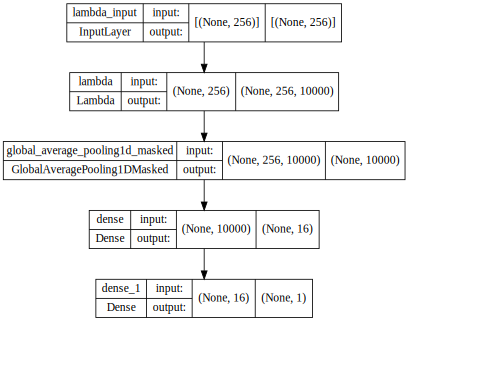

In [16]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model_1, show_shapes=True, 
                           show_layer_names=True, dpi=60).create(prog='dot', format='svg'))

### Training the model

To compile the model we need a loss function and an optimizer. We use binary_crossentropy loss function which is just a special case of categorical cross entropy. We also use Adam optimizer that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data. We can read more about it here:
(https://arxiv.org/abs/1412.6980v8
)


In [17]:
model_1.compile(optimizer='adam',
                loss='binary_crossentropy',
              metrics=['accuracy'])

When training, we want to check the accuracy of the model on data it hasn't seen before. So we create a validation set:

In [18]:
X_val = np.array(X_train_enc[:10000])
partial_X_train = np.array(X_train_enc[10000:])

y_val = np.array(y_train[:10000])
partial_y_train = np.array(y_train[10000:])

Then we start to train the model for 40 epochs in mini-batches of 512 samples and monitor the model's loss and accuracy on the validation set.

In [19]:
history_1 = model_1.fit(partial_X_train,
                        partial_y_train,
                        epochs=40,
                        batch_size=512,
                        validation_data=(X_val, y_val),
                        verbose=1)

Epoch 1/40


2022-03-10 11:01:33.515823: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-10 11:01:33.701955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5088

2022-03-10 11:01:53.182170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 30s 873ms/step - loss: 0.6931 - accuracy: 0.5088 - val_loss: 0.6930 - val_accuracy: 0.5125
Epoch 2/40
30/30 [==============================] - 26s 887ms/step - loss: 0.6929 - accuracy: 0.5187 - val_loss: 0.6928 - val_accuracy: 0.5210
Epoch 3/40
30/30 [==============================] - 27s 892ms/step - loss: 0.6926 - accuracy: 0.5080 - val_loss: 0.6927 - val_accuracy: 0.5037
Epoch 4/40
30/30 [==============================] - 26s 862ms/step - loss: 0.6924 - accuracy: 0.5177 - val_loss: 0.6922 - val_accuracy: 0.5336
Epoch 5/40
30/30 [==============================] - 27s 886ms/step - loss: 0.6920 - accuracy: 0.5229 - val_loss: 0.6917 - val_accuracy: 0.5335
Epoch 6/40
30/30 [==============================] - 26s 876ms/step - loss: 0.6916 - accuracy: 0.5197 - val_loss: 0.6915 - val_accuracy: 0.5166
Epoch 7/40
30/30 [==============================] - 26s 887ms/step - loss: 0.6912 - accuracy: 0.5273 - val_loss: 0.6910 - val_accuracy: 0.5201
Epoch 8/40

### Evaluating the model

To evaulate the model on test data:

In [20]:
results_1 = model_1.evaluate(X_test_enc, y_test)

782/782 [==============================] - 32s 41ms/step - loss: 0.5701 - accuracy: 0.7320


In [21]:
print('test_loss:', results_1[0], 'test_accuracy:', results_1[1])# loss, accuracay 

test_loss: 0.5700706839561462 test_accuracy: 0.7320400476455688


Our first model accuracy using one-hot vectors is ~68%







### Plotting the accuracy graph

To plot a graph of accuracy and loss over time we can use Matplotlib:

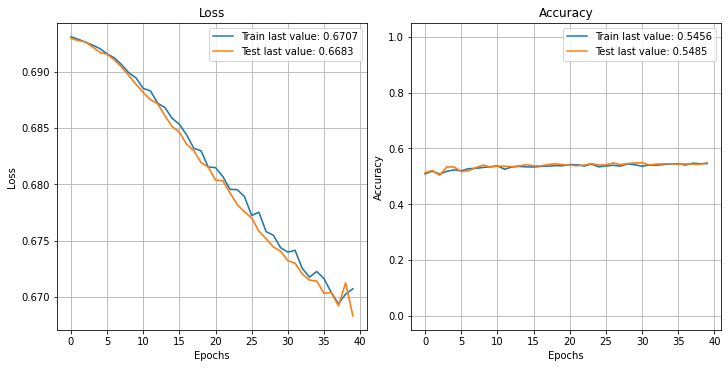

In [27]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history_1.history, path="standard.png")
plt.show()

# Model 2: Neural averaging network using embedding layer

Now instead of one-hot vectors, we want to use embedding. We change our first layer in model1 to an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

In [28]:
model_2 = Sequential()

# an embedding layer. 
model_2.add(Embedding(input_dim = VOCAB_SIZE, 
                      input_length = MAX_SEQUENCE_LENGTH,
                      output_dim = 100,
                      name='embedding'))

model_2.add(GlobalAveragePooling1DMasked())
model_2.add(Dense(hidden_layer))
model_2.add(Dense(1, activation= "sigmoid"))
model_2.summary()

model_2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 100)          1000000   
                                                                 
 global_average_pooling1d_ma  (None, 100)              0         
 sked_1 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_2 (Dense)             (None, 16)                1616      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,001,633
Trainable params: 1,001,633
Non-trainable params: 0
_________________________________________________________________


In [29]:
history_2 = model_2.fit(partial_X_train,
                       partial_y_train,
                       epochs=40,
                       batch_size=512,
                       validation_data=(X_val, y_val),
                       verbose=1)

Epoch 1/40


2022-03-10 11:23:08.738544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 7s 222ms/step - loss: 0.6865 - accuracy: 0.6447 - val_loss: 0.6760 - val_accuracy: 0.7094
Epoch 2/40


2022-03-10 11:23:15.571197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 7s 243ms/step - loss: 0.6544 - accuracy: 0.7345 - val_loss: 0.6295 - val_accuracy: 0.7352
Epoch 3/40
30/30 [==============================] - 7s 234ms/step - loss: 0.5864 - accuracy: 0.7709 - val_loss: 0.5543 - val_accuracy: 0.7795
Epoch 4/40
30/30 [==============================] - 7s 248ms/step - loss: 0.4973 - accuracy: 0.8160 - val_loss: 0.4716 - val_accuracy: 0.8197
Epoch 5/40
30/30 [==============================] - 7s 240ms/step - loss: 0.4126 - accuracy: 0.8540 - val_loss: 0.4074 - val_accuracy: 0.8446
Epoch 6/40
30/30 [==============================] - 7s 237ms/step - loss: 0.3485 - accuracy: 0.8769 - val_loss: 0.3628 - val_accuracy: 0.8614
Epoch 7/40
30/30 [==============================] - 7s 240ms/step - loss: 0.3036 - accuracy: 0.8915 - val_loss: 0.3353 - val_accuracy: 0.8674
Epoch 8/40
30/30 [==============================] - 7s 249ms/step - loss: 0.2686 - accuracy: 0.9047 - val_loss: 0.3170 - val_accuracy: 0.8745
Epoch 9/40
30/30 

In [30]:
results_2 = model_2.evaluate(X_test_enc, y_test)
print('test_loss:', results_2[0], 'test_accuracy:', results_2[1])

782/782 [==============================] - 3s 4ms/step - loss: 0.5909 - accuracy: 0.8515
test_loss: 0.5909416675567627 test_accuracy: 0.8514800667762756


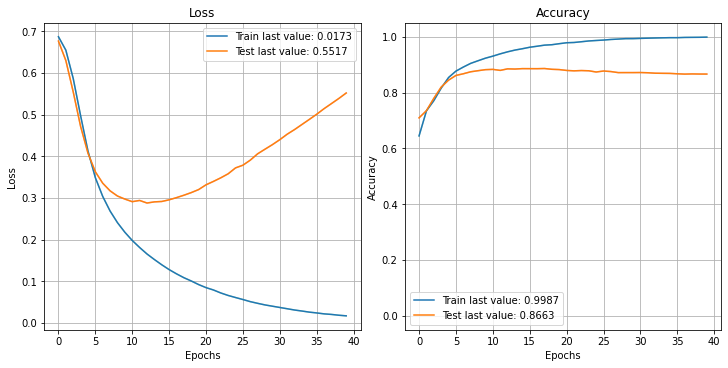

In [31]:
plot_history(history_2.history, path="standard.png")
plt.show()

The accuracy of model2 is 87%. Using Embedding layer instead of one-hot layer improved the performance.

# Model 3: Using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings, which we can read about it here (https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics. We can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in our dataset.
First, we need to read GloVe and map words to GloVe:


In [32]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [33]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, 
                               embeddings_initializer=Constant(embeddingMatrix), 
                               trainable=isTrainable, 
                               name='GloVe_Embeddings')
    return embeddingLayer

In [34]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip '/content/glove.6B.zip'

In [35]:
import os
data = os.path.expanduser("/Users/jiahao/Downloads/Neural Networks and NLP/Week 3/content/glove.6B.300d.txt")

# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile(data)

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer = createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  300


## Model 3-1: Neural bag of words using pre-trained word embeddings

Now we change our model to use GloVe:

In [52]:
# Inspect model performance with 1 hidden layer, pre-trained embeddings

model_3_1 = Sequential()

# an embedding layer. 
model_3_1.add(embeddingLayer)

model_3_1.add(GlobalAveragePooling1D())
model_3_1.add(Dense(16))
model_3_1.add(Dense(1, activation= "sigmoid"))
model_3_1.summary()

model_3_1.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embeddings (Embedding  (None, None, 300)        120000300 
 )                                                               
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_18 (Dense)            (None, 16)                4816      
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 120,005,133
Trainable params: 4,833
Non-trainable params: 120,000,300
_________________________________________________________________


In [53]:
# Train and test the model
history_3_1 = model_3_1.fit(partial_X_train,
                        partial_y_train,
                        epochs=40,
                        batch_size=512,
                        validation_data=(X_val, y_val),
                        verbose=1)

results_3_1 = model_3_1.evaluate(X_test_enc, y_test)
print('\n')
print('test_loss:', results_3_1[0], 'test_accuracy:', results_3_1[1])

Epoch 1/40


2022-03-10 12:15:03.626489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.5531

2022-03-10 12:15:04.569317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 33ms/step - loss: 0.6869 - accuracy: 0.5531 - val_loss: 0.6815 - val_accuracy: 0.5791
Epoch 2/40
30/30 [==============================] - 1s 19ms/step - loss: 0.6760 - accuracy: 0.5854 - val_loss: 0.6729 - val_accuracy: 0.5902
Epoch 3/40
30/30 [==============================] - 1s 19ms/step - loss: 0.6682 - accuracy: 0.6026 - val_loss: 0.6675 - val_accuracy: 0.6035
Epoch 4/40
30/30 [==============================] - 1s 20ms/step - loss: 0.6594 - accuracy: 0.6193 - val_loss: 0.6574 - val_accuracy: 0.6237
Epoch 5/40
30/30 [==============================] - 1s 19ms/step - loss: 0.6523 - accuracy: 0.6302 - val_loss: 0.6495 - val_accuracy: 0.6355
Epoch 6/40
30/30 [==============================] - 1s 19ms/step - loss: 0.6433 - accuracy: 0.6503 - val_loss: 0.6424 - val_accuracy: 0.6471
Epoch 7/40
30/30 [==============================] - 1s 19ms/step - loss: 0.6354 - accuracy: 0.6580 - val_loss: 0.6349 - val_accuracy: 0.6549
Epoch 8/40
30/30 [======

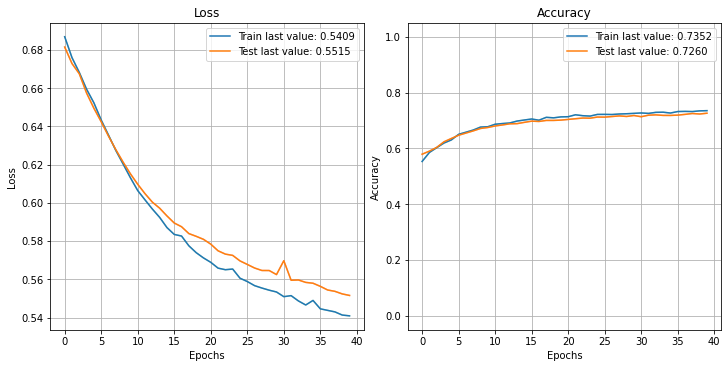

In [54]:
plot_history(history_3_1.history, path="standard.png")
plt.show()

To compare freezing and fine-tuning the pre-train embedding weights, we fine-tune the weights here:

In [38]:
model_3_1 = Sequential()

# an embedding layer. 
model_3_1.add(createPretrainedEmbeddingLayer(wordToGlove,
                                             wordToIndex,
                                             isTrainable=True))
model_3_1.add(GlobalAveragePooling1DMasked())
model_3_1.add(Dense(16))
model_3_1.add(Dense(1, activation= "sigmoid"))
model_3_1.summary()

model_3_1.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embeddings (Embedding  (None, None, 300)        120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_2 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_6 (Dense)             (None, 16)                4816      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 120,005,133
Trainable params: 120,005,133
Non-trainable params: 0
________________________________________

In [39]:
# Train and test the model
history_3_1 = model_3_1.fit(partial_X_train,
                      partial_y_train,
                      epochs=40,
                      batch_size=512,
                      validation_data=(X_val, y_val),
                      verbose=1)

results_3_1 = model_3_1.evaluate(X_test_enc, y_test)
print('test_loss:', results_3_1[0], 'test_accuracy:', results_3_1[1])

Epoch 1/40


2022-03-10 11:28:31.697066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6798 - accuracy: 0.5855

2022-03-10 11:28:46.466368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 15s 482ms/step - loss: 0.6798 - accuracy: 0.5855 - val_loss: 0.6657 - val_accuracy: 0.6355
Epoch 2/40
30/30 [==============================] - 14s 466ms/step - loss: 0.6444 - accuracy: 0.6686 - val_loss: 0.6257 - val_accuracy: 0.6774
Epoch 3/40
30/30 [==============================] - 14s 465ms/step - loss: 0.5898 - accuracy: 0.7244 - val_loss: 0.5606 - val_accuracy: 0.7521
Epoch 4/40
30/30 [==============================] - 14s 460ms/step - loss: 0.5111 - accuracy: 0.7897 - val_loss: 0.4830 - val_accuracy: 0.8058
Epoch 5/40
30/30 [==============================] - 14s 454ms/step - loss: 0.4266 - accuracy: 0.8381 - val_loss: 0.4154 - val_accuracy: 0.8338
Epoch 6/40
30/30 [==============================] - 14s 469ms/step - loss: 0.3593 - accuracy: 0.8669 - val_loss: 0.3687 - val_accuracy: 0.8543
Epoch 7/40
30/30 [==============================] - 14s 468ms/step - loss: 0.3105 - accuracy: 0.8859 - val_loss: 0.3391 - val_accuracy: 0.8664
Epoch 8/40

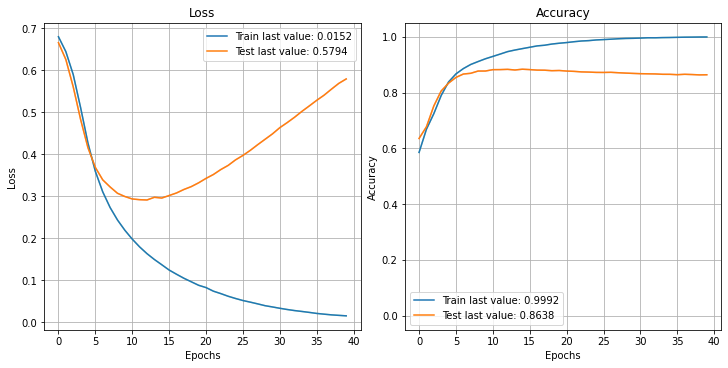

In [51]:
plot_history(history_3_1.history, path="standard.png")
plt.show()

Experiments here show that fine-tuning the pre-trained embeddings would obtain better accuracy.

Note that although fine-tuning the pre-trained embeddings is better here, we do not fine-tune it in other models. We could conduct extra experiments to compare the results.

##  Model 3-2: LSTM with pre-trained word embeddings

In previous labs, we have conducted an experiment based on LSTM. Now, we replace its embeddings with the GloVe pre-trained embeddings.

In [40]:
from keras.layers import LSTM
model_3_2 = Sequential()

model_3_2.add(embeddingLayer)
model_3_2.add(LSTM(100, return_sequences = False))
model_3_2.add(Dense(1, activation= "sigmoid"))
model_3_2.summary()

model_3_2.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embeddings (Embedding  (None, None, 300)        120000300 
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 120,160,801
Trainable params: 160,501
Non-trainable params: 120,000,300
_________________________________________________________________


In [41]:
# Train and test the model

history_3_2 = model_3_2.fit(partial_X_train,
                      partial_y_train,
                      epochs=40,
                      batch_size=512,
                      validation_data=(X_val, y_val),
                      verbose=1)

results_3_2 = model_3_2.evaluate(X_test_enc, y_test)
print('test_loss:', results_3_2[0], 'test_accuracy:', results_3_2[1])

Epoch 1/40


2022-03-10 11:37:38.061103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-10 11:37:38.209465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-10 11:37:39.805671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5107

2022-03-10 11:37:51.370572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-10 11:37:51.427995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 16s 421ms/step - loss: 0.6924 - accuracy: 0.5107 - val_loss: 0.6889 - val_accuracy: 0.5156
Epoch 2/40
30/30 [==============================] - 10s 348ms/step - loss: 0.6824 - accuracy: 0.5359 - val_loss: 0.6815 - val_accuracy: 0.5292
Epoch 3/40
30/30 [==============================] - 10s 347ms/step - loss: 0.6714 - accuracy: 0.5519 - val_loss: 0.6787 - val_accuracy: 0.5312
Epoch 4/40
30/30 [==============================] - 10s 347ms/step - loss: 0.6865 - accuracy: 0.5613 - val_loss: 0.6832 - val_accuracy: 0.5263
Epoch 5/40
30/30 [==============================] - 10s 349ms/step - loss: 0.6630 - accuracy: 0.5597 - val_loss: 0.6754 - val_accuracy: 0.5340
Epoch 6/40
30/30 [==============================] - 10s 351ms/step - loss: 0.6556 - accuracy: 0.5698 - val_loss: 0.6717 - val_accuracy: 0.5420
Epoch 7/40
30/30 [==============================] - 10s 346ms/step - loss: 0.6456 - accuracy: 0.5746 - val_loss: 0.6664 - val_accuracy: 0.5492
Epoch 8/40

Experiment show that simply replacing the lab 2 model embeddings with pre-trained word embeddings (GloVe) will cause performance to drop significantly.

#  Model 4: Adding extra dense layer into Neural averaging network model

We add extra dense layers into model 3-1 (neural network model) to evaluate extra dense layers' contribution. We start by adding one layer, then add two. All parameters are the same as model 3-1.

### Adding one extra dense layer

In [55]:
# Inspect model performance with 1 hidden layer, pre-trained embeddings

model_4 = Sequential()
model_4.add(embeddingLayer)
model_4.add(GlobalAveragePooling1DMasked())
model_4.add(Dense(100))
model_4.add(Dense(16))
model_4.add(Dense(1, activation= "sigmoid"))
model_4.summary()

model_4.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

history_4 = model_4.fit(partial_X_train,
                      partial_y_train,
                      epochs=40,
                      batch_size=512,
                      validation_data=(X_val, y_val),
                      verbose=1)

results_4 = model_4.evaluate(X_test_enc, y_test)

print('test_loss:', results_4[0], 'test_accuracy:', results_4[1])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embeddings (Embedding  (None, None, 300)        120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_5 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_20 (Dense)            (None, 100)               30100     
                                                                 
 dense_21 (Dense)            (None, 16)                1616      
                                                                 
 dense_22 (Dense)            (None, 1)                 17        
                                                     

2022-03-10 12:29:45.621110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6827 - accuracy: 0.5564

2022-03-10 12:29:46.472942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 29ms/step - loss: 0.6827 - accuracy: 0.5564 - val_loss: 0.6689 - val_accuracy: 0.5979
Epoch 2/40
30/30 [==============================] - 1s 20ms/step - loss: 0.6586 - accuracy: 0.6202 - val_loss: 0.6594 - val_accuracy: 0.5992
Epoch 3/40
30/30 [==============================] - 1s 20ms/step - loss: 0.6352 - accuracy: 0.6544 - val_loss: 0.6243 - val_accuracy: 0.6639
Epoch 4/40
30/30 [==============================] - 1s 20ms/step - loss: 0.6113 - accuracy: 0.6741 - val_loss: 0.6051 - val_accuracy: 0.6784
Epoch 5/40
30/30 [==============================] - 1s 20ms/step - loss: 0.5943 - accuracy: 0.6859 - val_loss: 0.6011 - val_accuracy: 0.6814
Epoch 6/40
30/30 [==============================] - 1s 20ms/step - loss: 0.5794 - accuracy: 0.7039 - val_loss: 0.5813 - val_accuracy: 0.6995
Epoch 7/40
30/30 [==============================] - 1s 20ms/step - loss: 0.5700 - accuracy: 0.7095 - val_loss: 0.5748 - val_accuracy: 0.7066
Epoch 8/40
30/30 [======

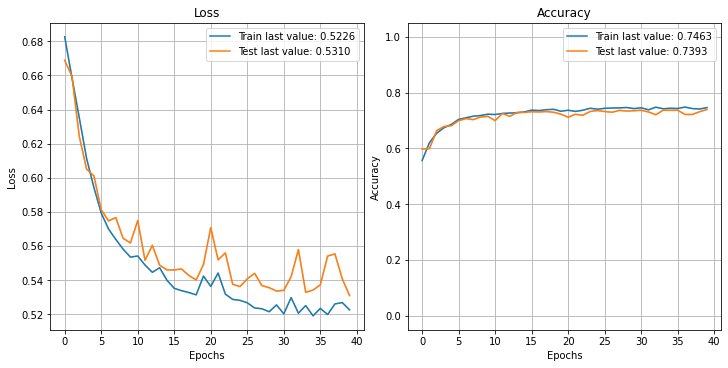

In [56]:
plot_history(history_4.history, path="standard.png")
plt.show()

### Adding two extra dense layers

In [44]:
# Inspect model performance with 2 hidden layer, pre-trained embeddings

model_4 = Sequential()
model_4.add(embeddingLayer)
model_4.add(GlobalAveragePooling1DMasked())
model_4.add(Dense(300))
model_4.add(Dense(100))
model_4.add(Dense(16))
model_4.add(Dense(1, activation= "sigmoid"))
model_4.summary()

model_4.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

history_4 = model_4.fit(partial_X_train,
                      partial_y_train,
                      epochs=40,
                      batch_size=512,
                      validation_data=(X_val, y_val),
                      verbose=1)

results_4 = model_4.evaluate(X_test_enc, y_test)
print ('\n')
print('test_loss:', results_4[0], 'test_accuracy:', results_4[1])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embeddings (Embedding  (None, None, 300)        120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_4 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_12 (Dense)            (None, 300)               90300     
                                                                 
 dense_13 (Dense)            (None, 100)               30100     
                                                                 
 dense_14 (Dense)            (None, 16)                1616      
                                                      

2022-03-10 11:45:57.455004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.7004 - accuracy: 0.5307

2022-03-10 11:45:58.262413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 30ms/step - loss: 0.7004 - accuracy: 0.5307 - val_loss: 0.6727 - val_accuracy: 0.5889
Epoch 2/40
30/30 [==============================] - 1s 19ms/step - loss: 0.6582 - accuracy: 0.6155 - val_loss: 0.6425 - val_accuracy: 0.6327
Epoch 3/40
30/30 [==============================] - 1s 19ms/step - loss: 0.6137 - accuracy: 0.6705 - val_loss: 0.5998 - val_accuracy: 0.6790
Epoch 4/40
30/30 [==============================] - 1s 19ms/step - loss: 0.5921 - accuracy: 0.6880 - val_loss: 0.5849 - val_accuracy: 0.6947
Epoch 5/40
30/30 [==============================] - 1s 19ms/step - loss: 0.5748 - accuracy: 0.7065 - val_loss: 0.5703 - val_accuracy: 0.7120
Epoch 6/40
30/30 [==============================] - 1s 19ms/step - loss: 0.5576 - accuracy: 0.7179 - val_loss: 0.5611 - val_accuracy: 0.7182
Epoch 7/40
30/30 [==============================] - 1s 19ms/step - loss: 0.5529 - accuracy: 0.7245 - val_loss: 0.5633 - val_accuracy: 0.7145
Epoch 8/40
30/30 [======

These two experiments show that adding extra dense layers can slightly improve accuracy over model 3-1.

---



#  Model 5: CNN for Text Classification

In this section, we build a Convolutional Neural Network (CNN) for text classification. We start by using one CNN layer and then adding another layer. We could use embeddings from pre-trained or scratch.

##  Model 5-1: Basic CNN model for Text Classification 

In [45]:
from keras.layers import GlobalMaxPooling1D

model_5 = Sequential()
model_5.add(Embedding(input_dim = VOCAB_SIZE, 
                     output_dim = EMBED_SIZE,
                     name='embedding', 
                     input_length = MAX_SEQUENCE_LENGTH))
model_5.add(Conv1D(filters = 100, kernel_size = 6))
model_5.add(GlobalMaxPooling1D())
model_5.add(Dense(1, activation = "sigmoid"))
model_5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 300)          3000000   
                                                                 
 conv1d (Conv1D)             (None, 251, 100)          180100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_16 (Dense)            (None, 1)                 101       
                                                                 
Total params: 3,180,201
Trainable params: 3,180,201
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Train and test the model

model_5.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history_5 = model_5.fit(partial_X_train,
                       partial_y_train,
                       epochs=40,
                       batch_size=512,
                       validation_data=(X_val, y_val),
                       verbose=1)

results_5 = model_5.evaluate(X_test_enc, y_test)
print ('\n')
print('test_loss:', results_5[0], 'test_accuracy:', results_5[1])

Epoch 1/40


2022-03-10 11:46:24.709771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6631 - accuracy: 0.6288

2022-03-10 11:46:33.836405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 10s 307ms/step - loss: 0.6631 - accuracy: 0.6288 - val_loss: 0.5973 - val_accuracy: 0.7547
Epoch 2/40
30/30 [==============================] - 7s 235ms/step - loss: 0.4895 - accuracy: 0.7981 - val_loss: 0.4072 - val_accuracy: 0.8243
Epoch 3/40
30/30 [==============================] - 8s 262ms/step - loss: 0.3214 - accuracy: 0.8720 - val_loss: 0.3363 - val_accuracy: 0.8537
Epoch 4/40
30/30 [==============================] - 7s 238ms/step - loss: 0.2189 - accuracy: 0.9237 - val_loss: 0.3129 - val_accuracy: 0.8678
Epoch 5/40
30/30 [==============================] - 7s 240ms/step - loss: 0.1448 - accuracy: 0.9587 - val_loss: 0.3111 - val_accuracy: 0.8693
Epoch 6/40
30/30 [==============================] - 7s 242ms/step - loss: 0.0892 - accuracy: 0.9813 - val_loss: 0.3280 - val_accuracy: 0.8682
Epoch 7/40
30/30 [==============================] - 6s 215ms/step - loss: 0.0540 - accuracy: 0.9919 - val_loss: 0.3505 - val_accuracy: 0.8663
Epoch 8/40
30/30

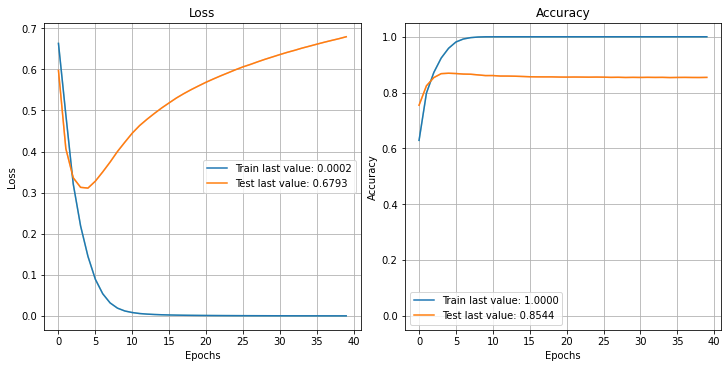

In [47]:
plot_history(history_5.history, path="standard.png")
plt.show()

## Model 5-2: Adding extra convolutional layer

In [48]:
model_5_2 = Sequential()
model_5_2.add(Embedding(input_dim = VOCAB_SIZE, 
                      output_dim = EMBED_SIZE,
                      name='embedding', 
                      input_length = MAX_SEQUENCE_LENGTH))
model_5_2.add(Conv1D(filters = 100, kernel_size = 6))
model_5_2.add(Conv1D(filters = 100, kernel_size = 6))
model_5_2.add(GlobalMaxPooling1D())
model_5_2.add(Dense(1, activation = "sigmoid"))
model_5_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 300)          3000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 251, 100)          180100    
                                                                 
 conv1d_2 (Conv1D)           (None, 246, 100)          60100     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_17 (Dense)            (None, 1)                 101       
                                                                 
Total params: 3,240,301
Trainable params: 3,240,301
Non-trainable params: 0
____________________________________________

In [49]:
# Train and test the model

model_5_2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

history_5_2 = model_5_2.fit(partial_X_train,
                      partial_y_train,
                      epochs=40,
                      batch_size=512,
                      validation_data=(X_val, y_val),
                      verbose=1)

results_5_2 = model_5_2.evaluate(X_test_enc, y_test)
print ('\n')
print('test_loss:', results_5_2[0], 'test_accuracy:', results_5_2[1])

Epoch 1/40


2022-03-10 11:50:47.939552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6283 - accuracy: 0.6492

2022-03-10 11:50:55.481144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 9s 291ms/step - loss: 0.6283 - accuracy: 0.6492 - val_loss: 0.4685 - val_accuracy: 0.7736
Epoch 2/40
30/30 [==============================] - 9s 297ms/step - loss: 0.3676 - accuracy: 0.8412 - val_loss: 0.3514 - val_accuracy: 0.8491
Epoch 3/40
30/30 [==============================] - 8s 279ms/step - loss: 0.2240 - accuracy: 0.9169 - val_loss: 0.3620 - val_accuracy: 0.8498
Epoch 4/40
30/30 [==============================] - 8s 274ms/step - loss: 0.1297 - accuracy: 0.9558 - val_loss: 0.4166 - val_accuracy: 0.8447
Epoch 5/40
30/30 [==============================] - 8s 277ms/step - loss: 0.0636 - accuracy: 0.9815 - val_loss: 0.5187 - val_accuracy: 0.8423
Epoch 6/40
30/30 [==============================] - 8s 273ms/step - loss: 0.0300 - accuracy: 0.9928 - val_loss: 0.6049 - val_accuracy: 0.8381
Epoch 7/40
30/30 [==============================] - 8s 283ms/step - loss: 0.0133 - accuracy: 0.9974 - val_loss: 0.7167 - val_accuracy: 0.8335
Epoch 8/40
30/30 

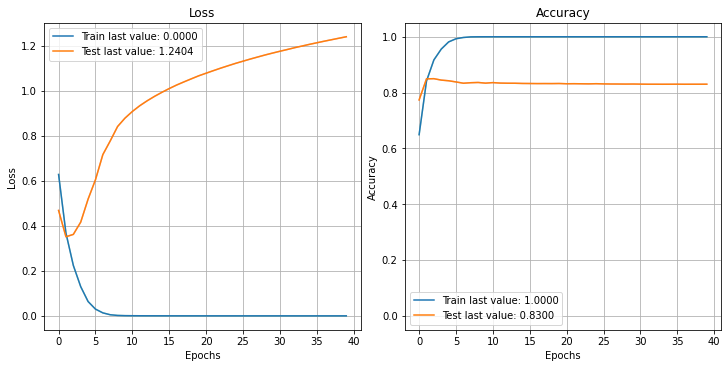

In [50]:
plot_history(history_5_2.history, path="standard.png")
plt.show()

Although adding layer here reduces the training loss, the evaluation accuracy is worse than the model without the extra convolutional layer.

Adding more layers can help us to extract more features. But we can do that up to a certain extent. After some point, instead of extracting features, we tend to overfit the data. Overfitting can lead to errors in on form or another, such as false positives. It is not easy to choose the number of units in a hidden layer or the number of hidden layers in a neural network. For many applications, one hidden layer is enough. As a general rule, the number of units in that hidden layer is between the number of inputs and the number of outputs.
 The best way to decide on the number of units and hidden layers is to try various parameters. Train several neural networks with different numbers of hidden layers and neurons, and monitor the performance of them. We will have to experiment using a series of different architectures. 







---

